In [268]:
import torch 
import torch.nn as nn

import numpy 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from scipy.constants import g, pi 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [94]:
E = 100e9 # Pa
nu = .33 
thresh = nn.Threshold(0,0)

In [335]:
class simulator():
    def __init__(self,n,r,rho,E,nu,pi=pi):
        self.n = n
        self.r = r
        self.m = 3/4 * r**3 * pi * rho
        self.x =  torch.rand((n,3),device=device)
        self.v = torch.zeros((n,3),device=device)
        self.a = torch.zeros((n,3),device=device)
        self.k = (2*r)**.5/3 * E/(1-nu**2)
        self.dt = pi/5*(self.m/self.k)**.5
        self.delta_nij = torch.zeros((n,n),device=device)
        self.tau_nij = torch.zeros((n,n),device=device)
        self.normals = torch.zeros((n,n),device=device)
        self.v_nij = torch.zeros((n,n),device=device)
        self.v_tij = torch.zeros((n,n),device=device)
        self.tangentials = torch.zeros((n,n),device=device)
        self.positions_history = []

    def run(self,timesteps):
        for _ in range(timesteps):
            self.update_overlap()
            self.update_force()
            self.step()
            self.positions_history.append(self.x.cpu().clone())

    def step(self):
        self.v += self.a * self.dt
        self.x += self.v * self.dt

    def update_overlap(self):
        """
        Calculates  delta_nij
                    diff_v
                    normals
                    tangentials
        """
        self.delta_nij *=0
        self.normals *=0
        self.tangentials *=0
        #Compute delta_nij -> the normal overlap between two particles
        diff = self.x.unsqueeze(0) - self.x.unsqueeze(1)  # Shape: (N, N, 3)
        dist_sq = diff.pow(2).sum(dim=-1)  # Shape: (N, N) 
        dist=dist_sq**.5
        self.delta_nij = dist + torch.eye(self.n,device=device)
        self.delta_nij -= 2* self.r
        self.delta_nij = nn.functional.threshold((-self.delta_nij),0,0)
        #Compute the normal Vectros of the particles
        self.normals = diff/(dist.norm()+torch.eye(self.x.shape[0],device=device)).unsqueeze(-1)
        #Compute the relative v at contact point
        diff_v = self.v.unsqueeze(0) - self.v.unsqueeze(1)  # Shape: (N, N, 3)
        dist_v_sq = diff_v.pow(2).sum(dim=-1)  # Shape: (N, N) 
        rel_v = dist_v_sq**.5
        self.v_nij = (rel_v.unsqueeze(-1)*self.normals)
        self.v_nij *= self.normals
        ##Compute the tangetial v at contact point
        self.v_tij = diff_v - self.v_nij # TODO: omega???  - 1/2*(omega)
        ##Compute the tangential Vectros of the particles
        self.tangentials = self.v_tij/self.v_tij.norm()

    def update_force(self):
        self.a[:,2] = -g
        self.a += (self.normals*(self.delta_nij * self.k).unsqueeze(-1)).sum(dim=-2)
        print(sim.x[0])
    
    def get_positions_history(self):
        return self.positions_history


In [338]:
sim = simulator(512,.015,4500,E,nu)
print(sim.dt)
sim.run(100000)


1.4766314615275932e-06
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3630], device='cuda:0')
tensor([0.1592, 0.8097, 0.3

MovieWriter ffmpeg unavailable; using Pillow instead.


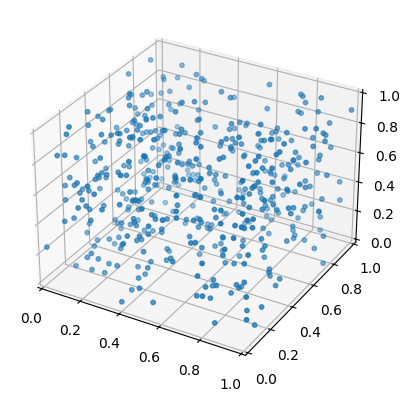

In [339]:
positions_history = sim.get_positions_history()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scat = ax.scatter([], [], [],s=10)
#ax.scatter(sim.x.T[0].cpu(),sim.x.T[1].cpu(),sim.x.T[2].cpu())
#plt.show()
def update_plot(frame):
    positions = positions_history[frame*100]
    scat._offsets3d = (positions[:, 0], positions[:, 1], positions[:, 2])
    return scat,

ani = FuncAnimation(fig, update_plot, frames=len(positions_history)//100, interval=16, blit=False)

ani.save('out.gif')

tensor([0.5830, 0.9360, 0.4789], device='cuda:0')